# modeling.ipynb

This notebook is concerned with the modeling component for Option C of the final project track: ***Prediction with GLMs and nonparametric methods***

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

## Summary of Brookings-FiveThirtyEight-FEC Dataset

**Candidate:** The name of the candidate.

**State:** The state where the candidate is running.

**District:** The specific district for House candidates.

**Office Type:** Whether the candidate is running for Senate, House, or Governor.

**Race Type:** Type of race (e.g., regular, special).

**Race Primary Election Date:** The date of the primary election.

**Primary Status:** Whether the candidate won or lost the primary.

**General Status:** The candidate's status in the general election.

**INDIV_CONTRIB:** Individual contributions.

**CAND_CONTRIB:** Candidate contributions.

**OTHER_POL_CMTE_CONTRIB:** Other political committee contributions.

**POL_PTY_CONTRIB:** Political party contributions.

**INDIV_REFUNDS:** Refunds to individuals.

**MTE_REFUNDS:** Refunds to committees.

**GEN_ELECTION:** Indicates if the candidate reached the general election.

**GEN_ELECTION_PRECENT:** The percentage of votes in the general election.

*As well as columns related to **endorsements** by various political entities and figures (e.g.: 'Biden Endorsed?', 'Emily Endorsed?', etc.)*


In [2]:
#merged_final_df.to_csv("demsmerge.csv")

In [3]:
merged_final_df = pd.read_csv("demsmerge.csv")

In [4]:
merged_final_df = merged_final_df.drop(columns = 'Unnamed: 0')

In [5]:
merged_final_df.columns

Index(['Candidate', 'State', 'District', 'Office Type', 'Race Type',
       'Race Primary Election Date', 'Primary Status', 'General Status',
       'CAND_CONTRIB', 'OTHER_POL_CMTE_CONTRIB', 'POL_PTY_CONTRIB',
       'INDIV_REFUNDS', 'CMTE_REFUNDS', 'CVG_END_DT', 'Emily Endorsed?',
       'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?'],
      dtype='object')

### OHE Categorical Columns

In [6]:
target_variable = 'Primary Status'

#but first we drop the 'General Status' Column
merged_final_df = merged_final_df.drop(columns = ['General Status'])

categorical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype == 'object' and col != target_variable]
numerical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype != 'object' and col != target_variable]

#One-Hot Encoding to categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(merged_final_df[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns)
df_prepared = pd.concat([merged_final_df[numerical_columns], df_encoded], axis=1)

#extract the target variable
y = merged_final_df[target_variable].apply(lambda x: 1 if x == 'Advanced' else 0)

# GLM: Logistic Regression

I naively selected logistic reg. since the target variable is whether or not the candidate makes it past the primaries.

We are modeling in the ✨ Frequentist Perspective ✨

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared, y, test_size=0.3, random_state=42)

### Random Over-Sampling

In [8]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
glm_model_ros = LogisticRegression(max_iter=1000)

In [9]:
glm_model_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = glm_model_ros.predict(X_test)

In [10]:
report_ros = classification_report(y_test, y_pred_ros)
conf_matrix_ros = confusion_matrix(y_test, y_pred_ros)

In [11]:
print("Report with ROS:", report_ros)

Report with ROS:               precision    recall  f1-score   support

           0       0.87      0.76      0.81        80
           1       0.71      0.84      0.77        55

    accuracy                           0.79       135
   macro avg       0.79      0.80      0.79       135
weighted avg       0.80      0.79      0.79       135



In [12]:
print("Confusion Matrix with ROS:")
print(conf_matrix_ros)

Confusion Matrix with ROS:
[[61 19]
 [ 9 46]]


### Random Under-Sampling

In [13]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
glm_model_rus = LogisticRegression(max_iter=1000)

In [14]:
glm_model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = glm_model_rus.predict(X_test)

In [15]:
report_rus = classification_report(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)

In [16]:
print("Report with RUS:", report_rus)

Report with RUS:               precision    recall  f1-score   support

           0       0.83      0.93      0.88        80
           1       0.87      0.73      0.79        55

    accuracy                           0.84       135
   macro avg       0.85      0.83      0.83       135
weighted avg       0.85      0.84      0.84       135



In [17]:
print("Confusion Matrix with RUS:")
print(conf_matrix_rus)

Confusion Matrix with RUS:
[[74  6]
 [15 40]]


### Cross-Validation for Random Over & Under-Sampling

In [18]:
cv_scores_ros = cross_val_score(glm_model_ros, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_mean_ros = np.mean(cv_scores_ros)
cv_scores_rus = cross_val_score(glm_model_rus, X_train_rus, y_train_rus, cv=5, scoring='accuracy')
cv_mean_rus = np.mean(cv_scores_rus)
print("CV Mean Accuracy with ROS:", cv_mean_ros)
print("CV Mean Accuracy with RUS:", cv_mean_rus)

CV Mean Accuracy with ROS: 0.8251228070175438
CV Mean Accuracy with RUS: 0.8647058823529413


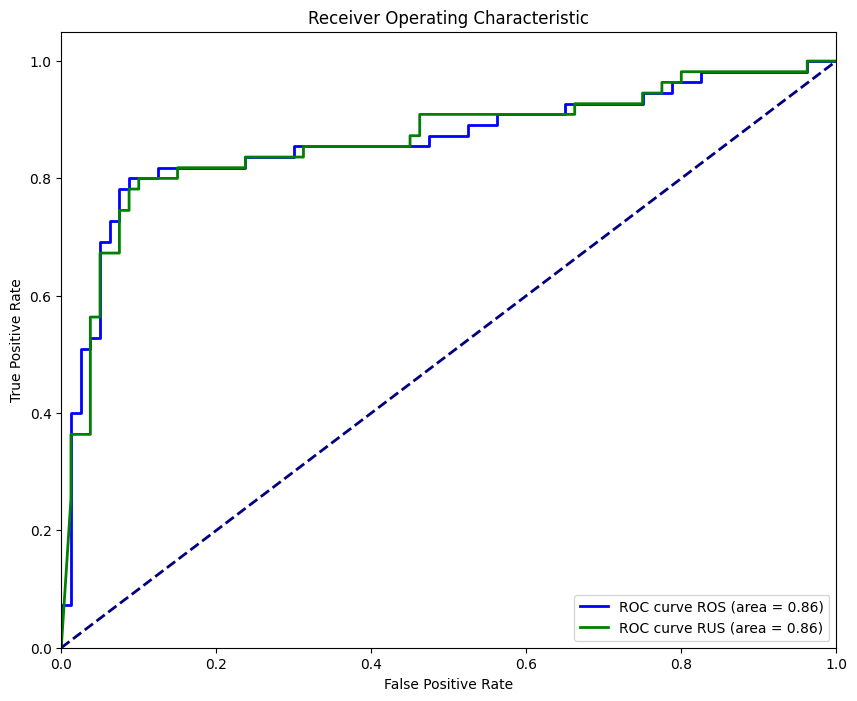

In [19]:
# ROC and AUC for over sampling
fpr_ros, tpr_ros, _ = roc_curve(y_test, glm_model_ros.predict_proba(X_test)[:, 1])
roc_auc_ros = auc(fpr_ros, tpr_ros)

# ROC and AUC for under sampling
fpr_rus, tpr_rus, _ = roc_curve(y_test, glm_model_rus.predict_proba(X_test)[:, 1])
roc_auc_rus = auc(fpr_rus, tpr_rus)

plt.figure(figsize=(10, 8))
plt.plot(fpr_ros, tpr_ros, color='blue', lw=2, label='ROC curve ROS (area = %0.2f)' % roc_auc_ros)
plt.plot(fpr_rus, tpr_rus, color='green', lw=2, label='ROC curve RUS (area = %0.2f)' % roc_auc_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Let's make a ✨ Decision Tree ✨

**Goal:** Predicting the `Primary Status` of a democratic candidate

The features selected for the Decision Tree model:

- State and District information: Providing geographical context which might influence primary outcomes.
  
- Office and Race Type: Indicating the type of political race, which could have differing and success factors.
  
- Financial Contributions (such as `CAND_CONTRIB`, `OTHER_POL_CMTE_CONTRIB`): Reflecting the financial strength and support for the campaign
  
- Endorsements (like `Emily Endorsed?`)

In [20]:
'''
features for decision tree model
NOTE: remove the 'General Status'
'''
decision_tree_features = merged_final_df.drop(columns=['Primary Status', 'Candidate']).columns.tolist()
decision_tree_features

['State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'CAND_CONTRIB',
 'OTHER_POL_CMTE_CONTRIB',
 'POL_PTY_CONTRIB',
 'INDIV_REFUNDS',
 'CMTE_REFUNDS',
 'CVG_END_DT',
 'Emily Endorsed?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?']

In [21]:
#features and target variable
X = merged_final_df[decision_tree_features]  
y = merged_final_df['Primary Status'].apply(lambda x: 1 if x == 'Advanced' else 0)  

In [22]:
#OHE
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
X_ohe = pd.get_dummies(X[categorical_columns])
X_prepared = pd.concat([X.drop(columns=categorical_columns), X_ohe], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

### Random Over-Sampling

In [24]:
ros = RandomOverSampler(random_state=42)
decision_tree_model_ros = DecisionTreeClassifier(random_state=42)

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#for cross validation
pipeline_ros = Pipeline([
    ('oversample', ros),
    ('model', decision_tree_model_ros)
])

In [25]:
decision_tree_model_ros.fit(X_train_ros, y_train_ros)

y_pred_ros = decision_tree_model_ros.predict(X_test)
accuracy_ros = accuracy_score(y_test, y_pred_ros)
class_report_ros = classification_report(y_test, y_pred_ros)

print(accuracy_ros)
print(class_report_ros)

0.8222222222222222
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        80
           1       0.77      0.80      0.79        55

    accuracy                           0.82       135
   macro avg       0.82      0.82      0.82       135
weighted avg       0.82      0.82      0.82       135



In [26]:
feature_importance_ros = decision_tree_model_ros.feature_importances_
feature_importance_ros_df = pd.DataFrame({
    'Feature': X_prepared.columns,
    'Importance': feature_importance_ros
}).sort_values(by='Importance', ascending=False).head(5)

feature_importance_ros_df.head(5)

,Feature,Importance
1,OTHER_POL_CMTE_CONTRIB,0.373005
3,INDIV_REFUNDS,0.131983
2,POL_PTY_CONTRIB,0.118178
332,CVG_END_DT_12/31/2018,0.043971
4,CMTE_REFUNDS,0.027237


### Random Under-Sampling

In [27]:
rus = RandomUnderSampler(random_state=42)
decision_tree_model_rus = DecisionTreeClassifier(random_state=42)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

#for cross validation
pipeline_rus = Pipeline([
    ('oversample', rus),
    ('model', decision_tree_model_rus)
])

In [28]:
decision_tree_model_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = decision_tree_model_rus.predict(X_test)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
class_report_rus = classification_report(y_test, y_pred_rus)

print(accuracy_rus)
print(class_report_rus)

0.8
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        80
           1       0.73      0.80      0.77        55

    accuracy                           0.80       135
   macro avg       0.79      0.80      0.80       135
weighted avg       0.80      0.80      0.80       135



In [29]:
feature_importance_rus = decision_tree_model_rus.feature_importances_
feature_importance_rus_df = pd.DataFrame({
    'Feature': X_prepared.columns,
    'Importance': feature_importance_rus
}).sort_values(by='Importance', ascending=False).head(5)

feature_importance_rus_df.head(5)

,Feature,Importance
1,OTHER_POL_CMTE_CONTRIB,0.383762
2,POL_PTY_CONTRIB,0.138667
3,INDIV_REFUNDS,0.137833
0,CAND_CONTRIB,0.050400
343,Justice Dems Endorsed?_No,0.036783


In [30]:
#Random Over-Sampling
y_pred_dt_ros = decision_tree_model_ros.predict(X_test)
mse_dt_ros = mean_squared_error(y_test, y_pred_dt_ros)

#Random Under-Sampling
y_pred_dt_rus = decision_tree_model_rus.predict(X_test)
mse_dt_rus = mean_squared_error(y_test, y_pred_dt_rus)

print("MSE for Decision Tree ROS:", mse_dt_ros)
print("MSE for Decision Tree RUS:", mse_dt_rus)

MSE for Decision Tree ROS: 0.17777777777777778
MSE for Decision Tree RUS: 0.2


### Cross-Validation

In [31]:
#cv - over sampling
cv_scores_ros = cross_val_score(pipeline_ros, X_prepared, y, cv=5, scoring='accuracy')
cv_mean_ros = np.mean(cv_scores_ros)

#cv - under sampling
cv_scores_rus = cross_val_score(pipeline_rus, X_prepared, y, cv=5, scoring='accuracy')
cv_mean_rus = np.mean(cv_scores_rus)

In [32]:
cv_mean_ros, cv_scores_ros

(0.8111111111111111,
 array([0.91111111, 0.75555556, 0.84444444, 0.8       , 0.74444444]))

In [33]:
cv_mean_rus, cv_scores_rus

(0.788888888888889,
 array([0.86666667, 0.78888889, 0.82222222, 0.75555556, 0.71111111]))

### Visualizations

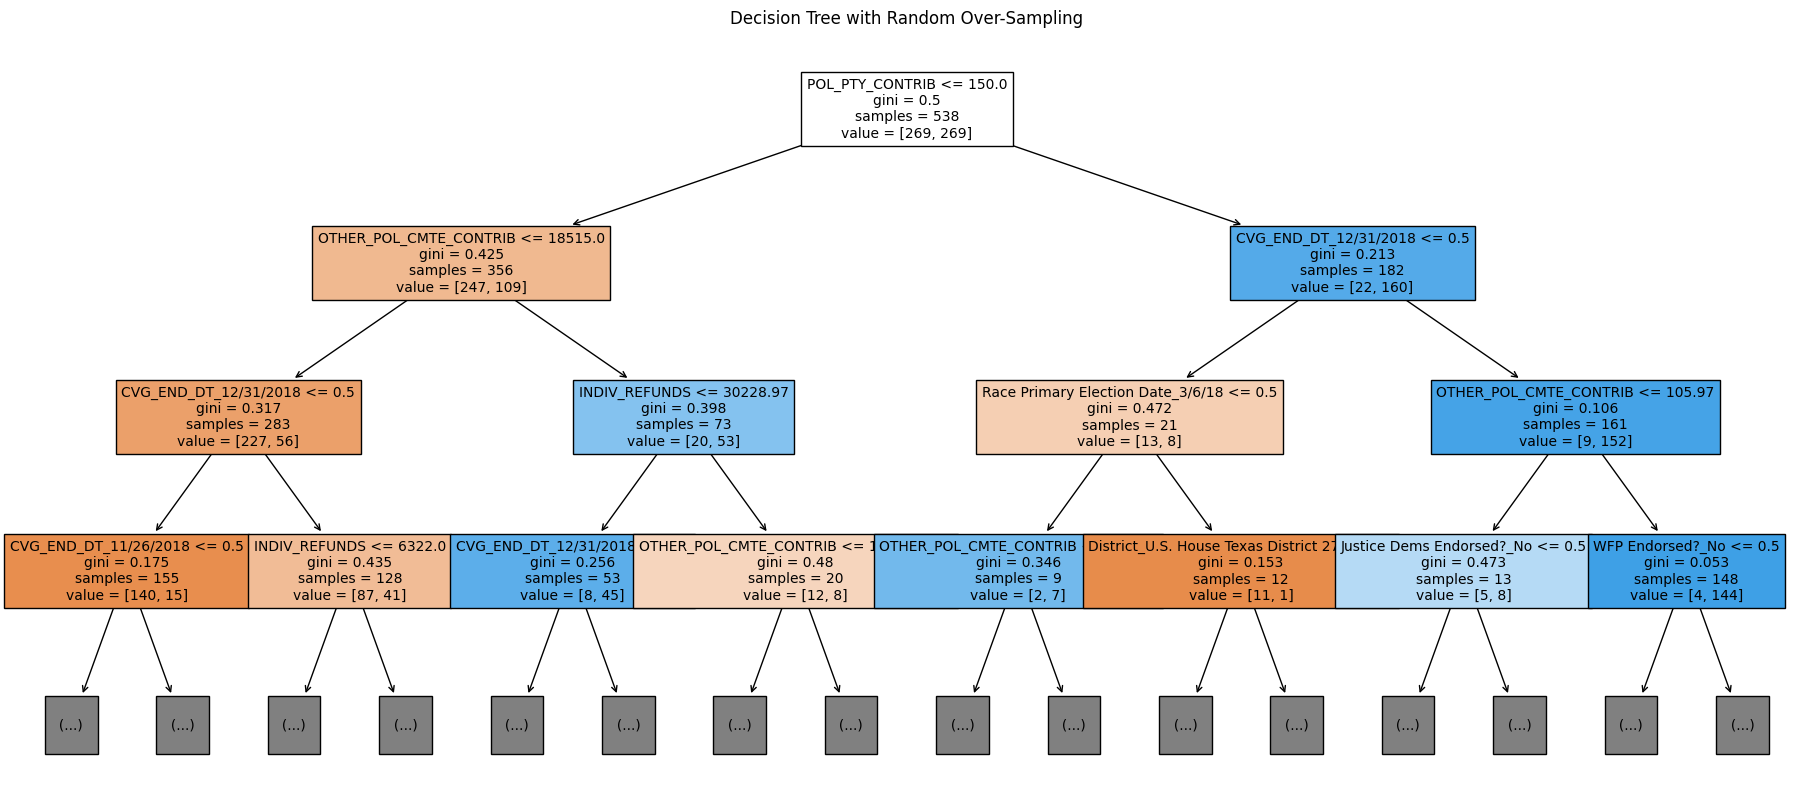

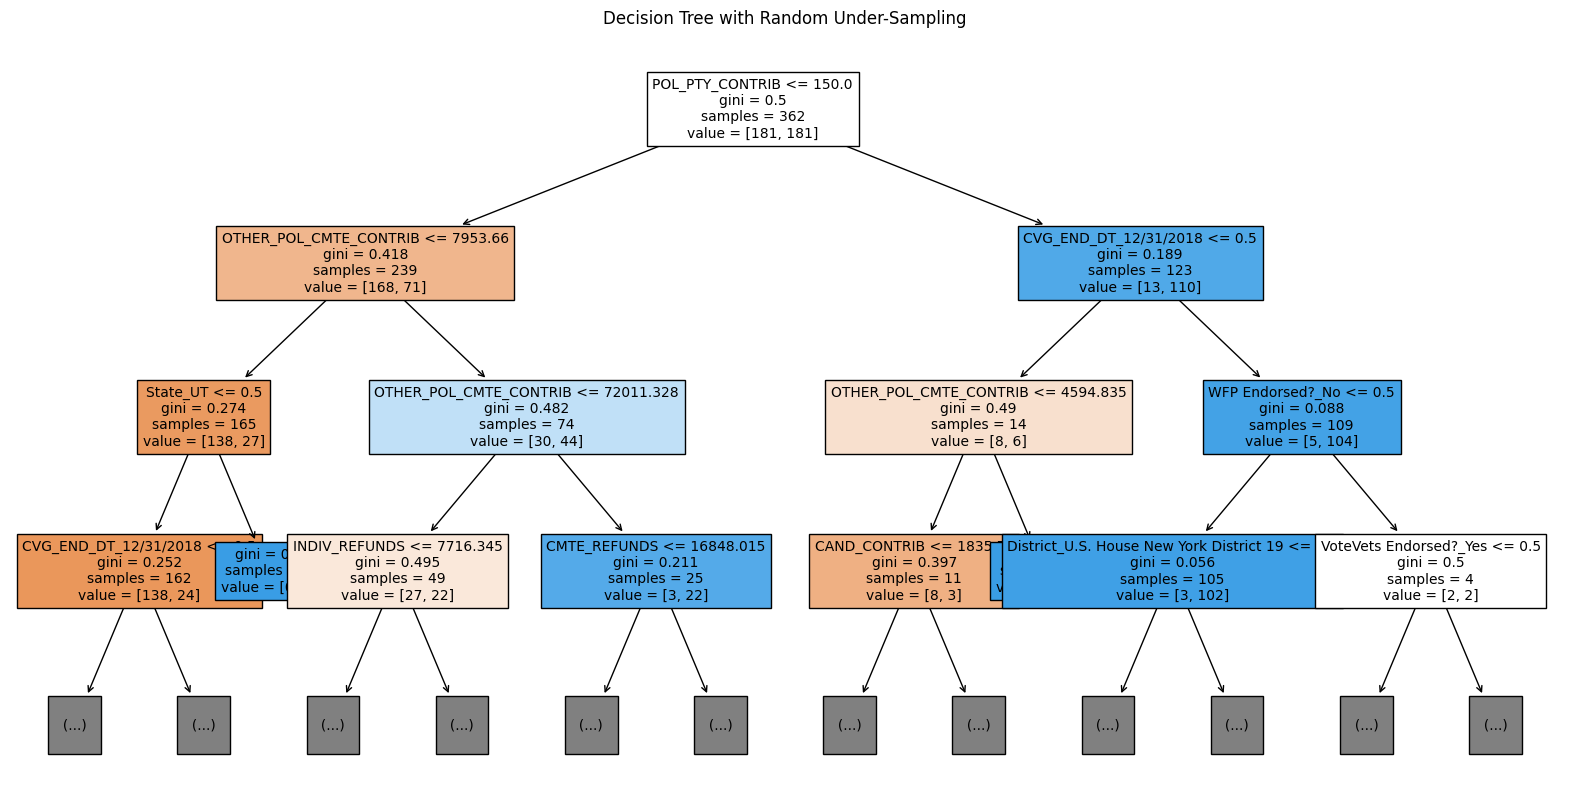

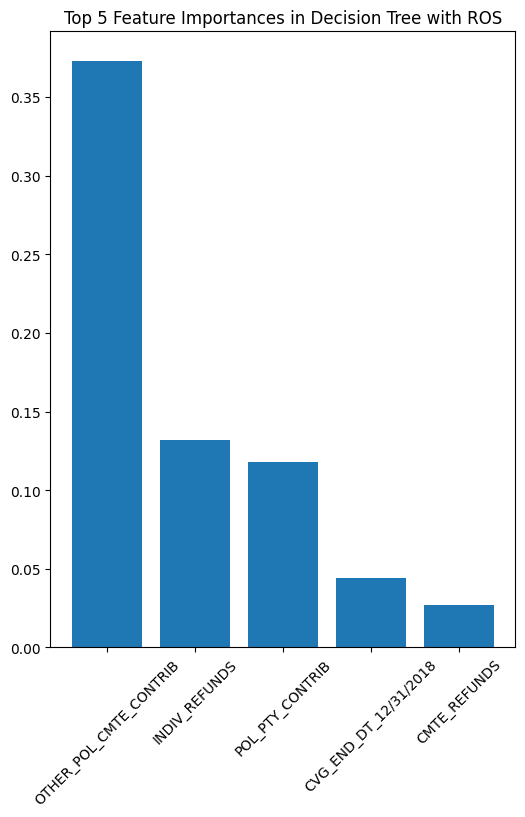

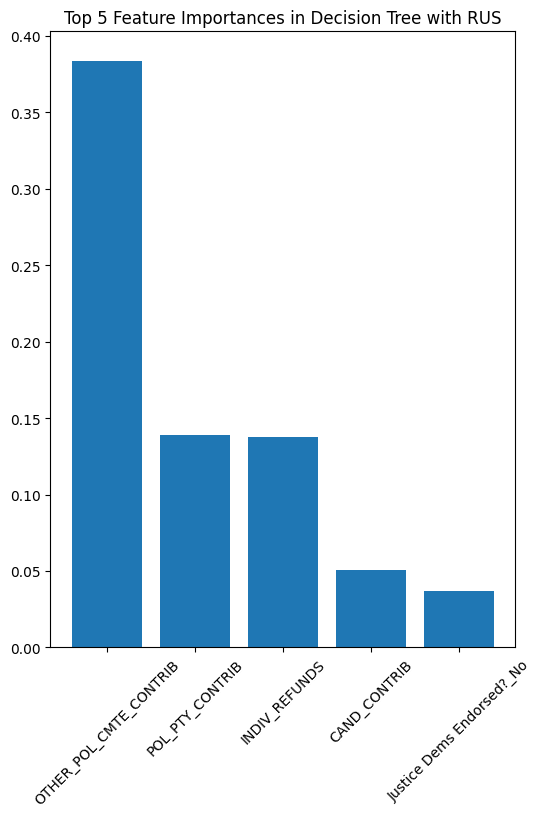

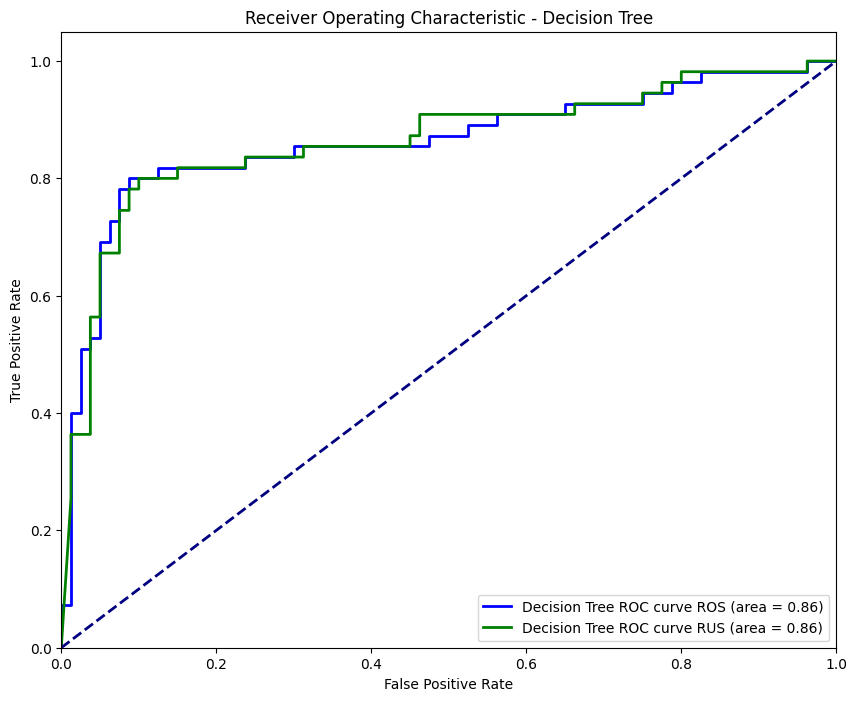

In [34]:
pipeline_ros.fit(X_prepared, y)
model_ros = pipeline_ros.named_steps['model']
pipeline_rus.fit(X_prepared, y)
model_rus = pipeline_rus.named_steps['model']

plt.figure(figsize=(23,10))
plot_tree(model_ros, filled=True, feature_names=X_prepared.columns, max_depth=3, fontsize=10)
plt.title("Decision Tree with Random Over-Sampling")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(model_rus, filled=True, feature_names=X_prepared.columns, max_depth=3, fontsize=10)
plt.title("Decision Tree with Random Under-Sampling")
plt.show()

plt.figure(figsize=(6, 8))
plt.title("Top 5 Feature Importances in Decision Tree with ROS")
plt.bar(feature_importance_ros_df['Feature'], feature_importance_ros_df['Importance'], align="center")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(6, 8))
plt.title("Top 5 Feature Importances in Decision Tree with RUS")
plt.bar(feature_importance_rus_df['Feature'], feature_importance_rus_df['Importance'], align="center")
plt.xticks(rotation=45)
plt.show()

# Calculating ROC Curve and AUC for Decision Tree with ROS
fpr_dt_ros, tpr_dt_ros, _ = roc_curve(y_test, decision_tree_model_ros.predict_proba(X_test)[:, 1])
roc_auc_dt_ros = auc(fpr_dt_ros, tpr_dt_ros)

# Calculating ROC Curve and AUC for Decision Tree with RUS
fpr_dt_rus, tpr_dt_rus, _ = roc_curve(y_test, decision_tree_model_rus.predict_proba(X_test)[:, 1])
roc_auc_dt_rus = auc(fpr_dt_rus, tpr_dt_rus)

# Plotting ROC Curves for Decision Tree models
plt.figure(figsize=(10, 8))
plt.plot(fpr_ros, tpr_ros, color='blue', lw=2, label='Decision Tree ROC curve ROS (area = %0.2f)' % roc_auc_ros)
plt.plot(fpr_rus, tpr_rus, color='green', lw=2, label='Decision Tree ROC curve RUS (area = %0.2f)' % roc_auc_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

# And the ✨ Random Forest ✨ 

### OHE Categorical Data

In [35]:
#Above this cell was previously run, but this would be the step taken prior to training the model

'''target_variable = 'Primary Status'

categorical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype == 'object' and col != target_variable]
numerical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype != 'object' and col != target_variable]

#OHE
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(merged_final_df[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns)
df_prepared = pd.concat([merged_final_df[numerical_columns], df_encoded], axis=1)

#target
y = merged_final_df[target_variable].apply(lambda x: 1 if x == 'Advanced' else 0)'''

'hi'

'hi'

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared, y, test_size=0.3, random_state=42)
random_forest = RandomForestClassifier(random_state=42)

### Random Over-Sampling

In [37]:
rf_ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = rf_ros.fit_resample(X_train, y_train)
rf_model_ros = RandomForestClassifier(random_state=42)
rf_model_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = rf_model_ros.predict(X_test)

In [38]:
report_ros = classification_report(y_test, y_pred_ros)
conf_matrix_ros = confusion_matrix(y_test, y_pred_ros)

In [39]:
print(report_ros)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88        80
           1       0.82      0.84      0.83        55

    accuracy                           0.86       135
   macro avg       0.85      0.86      0.85       135
weighted avg       0.86      0.86      0.86       135



In [40]:
conf_matrix_ros

array([[70, 10],
       [ 9, 46]])

### Random Under-Sampling

In [41]:
rf_rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rf_rus.fit_resample(X_train, y_train)

rf_model_rus = RandomForestClassifier(random_state=42)

rf_model_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = rf_model_rus.predict(X_test)

In [42]:
report_rus = classification_report(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)

In [43]:
print(report_rus)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87        80
           1       0.78      0.89      0.83        55

    accuracy                           0.85       135
   macro avg       0.85      0.86      0.85       135
weighted avg       0.86      0.85      0.85       135



In [44]:
conf_matrix_rus

array([[66, 14],
       [ 6, 49]])

In [45]:
y_pred_rf = rf_model_ros.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Mean Squared Error for the Random Forest model with Over-Sampling:", mse_rf)

Mean Squared Error for the Random Forest model with Over-Sampling: 0.14074074074074075


In [46]:
y_pred_rf = rf_model_rus.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Mean Squared Error for the Random Forest model with Under-Sampling:", mse_rf)

Mean Squared Error for the Random Forest model with Under-Sampling: 0.14814814814814814


### Cross-Validation for Over & Under-Sampling

In [47]:
cv_scores_ros = cross_val_score(rf_model_ros, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores_rus = cross_val_score(rf_model_rus, X_train_rus, y_train_rus, cv=5, scoring='accuracy')

cv_mean_ros = np.mean(cv_scores_ros)
cv_mean_rus = np.mean(cv_scores_rus)

In [48]:
print(cv_scores_ros)
cv_mean_ros

[0.82894737 0.92105263 0.90789474 0.94666667 0.89333333]


0.899578947368421

In [49]:
print(cv_scores_rus)
cv_mean_rus

[0.96078431 0.88235294 0.8        0.76       0.8       ]


0.8406274509803922

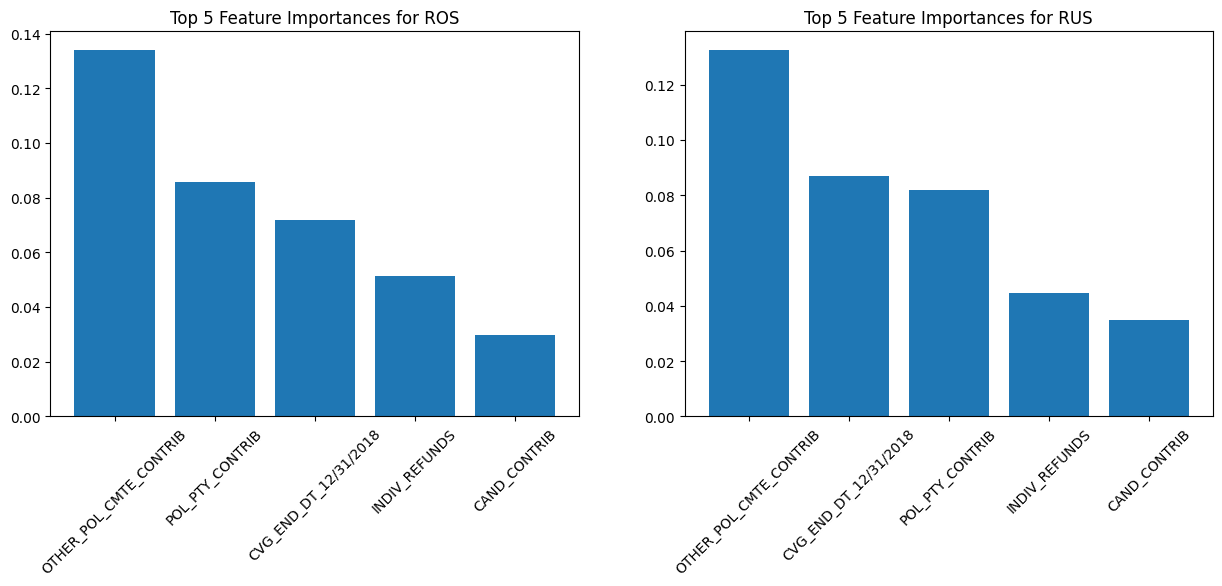

In [50]:
importances_ros = rf_model_ros.feature_importances_
importances_rus = rf_model_rus.feature_importances_

# Get the top 5 features for each model
indices_ros = np.argsort(importances_ros)[::-1][:5]
indices_rus = np.argsort(importances_rus)[::-1][:5]

# Plotting feature importances
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Top 5 Feature Importances for ROS')
plt.bar(range(5), importances_ros[indices_ros], align='center')
plt.xticks(range(5), X_train.columns[indices_ros], rotation=45)
plt.subplot(1, 2, 2)
plt.title('Top 5 Feature Importances for RUS')
plt.bar(range(5), importances_rus[indices_rus], align='center')
plt.xticks(range(5), X_train.columns[indices_rus], rotation=45)
plt.show()

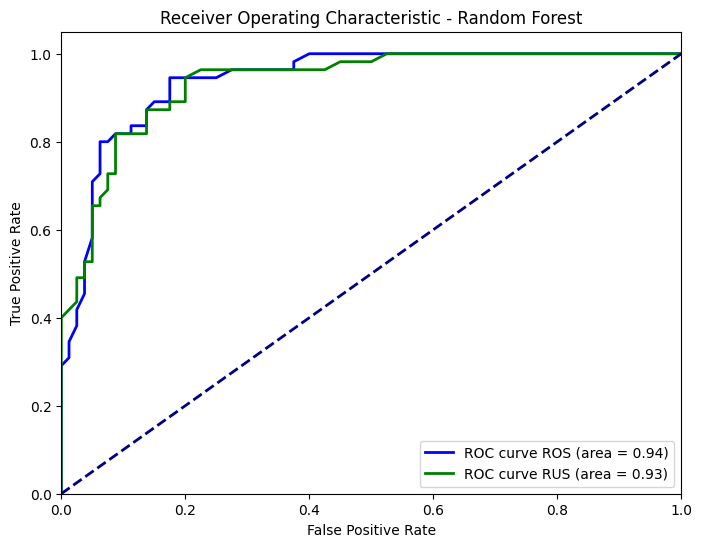

In [51]:
fpr_ros, tpr_ros, _ = roc_curve(y_test, rf_model_ros.predict_proba(X_test)[:, 1])
roc_auc_ros = auc(fpr_ros, tpr_ros)

# Calculating ROC Curve and AUC for RUS model
fpr_rus, tpr_rus, _ = roc_curve(y_test, rf_model_rus.predict_proba(X_test)[:, 1])
roc_auc_rus = auc(fpr_rus, tpr_rus)

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_ros, tpr_ros, color='blue', lw=2, label='ROC curve ROS (area = %0.2f)' % roc_auc_ros)
plt.plot(fpr_rus, tpr_rus, color='green', lw=2, label='ROC curve RUS (area = %0.2f)' % roc_auc_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()